# 部署機器學習模型 (2/2)

歡迎來到部署機器學習模型的第二部分。 **繼續之前請確認第一部分還在執行中。**

在這個 notebook 我們會利用 Python 的 `requests` 函式庫編寫一個最簡單的 client，並用它來跟 API 互動。

In [1]:
import os
import io
import cv2
import requests
import numpy as np
from IPython.display import Image, display

## URL 請求
### 拆解 URL

如果操作過幾次 fastAPI 內建的 client，或許會發現所有的請求都是藉由指向特定 URL 並在其後接上參數來完成：
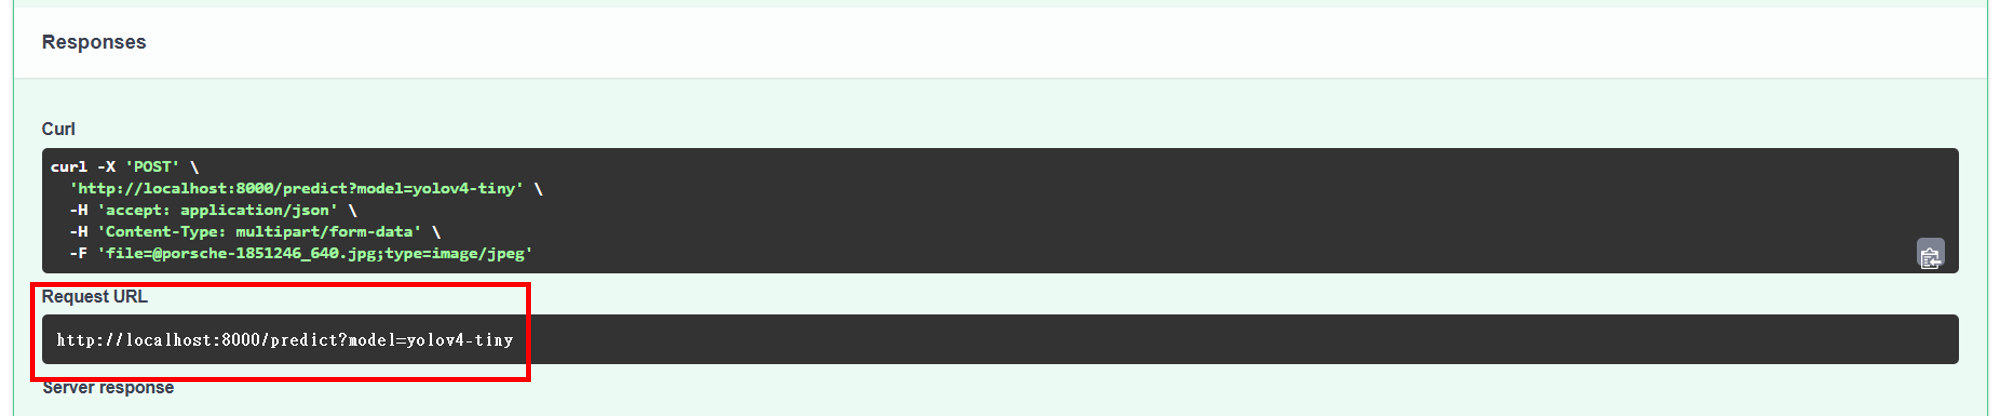

此 URL 的意義為：
- 伺服器 host 在 URL 位置 http://localhost:8000/ 之上。
- 模型則位於接口 `/predict` 上。

而後面則可以藉由模型的名稱 `yolov4`、`yolov4-tiny`、`yolov3` 或 `yolov3-tiny` 指定要使用的模型，這裡依然使用 `yolov4-tiny`。

首先，將所有參數資訊整理如下：

In [2]:
base_url = 'http://localhost:8000'
endpoint = '/predict'
model = 'yolov4-tiny'
confidence_level = 0.2

為了使用模型，要將接口 `endpoint` 接在 `base URL` 後來取得完整的 URL：

In [3]:
url_with_endpoint_no_params = base_url + endpoint
url_with_endpoint_no_params

'http://localhost:8000/predict'

> 注意此時還沒有加上參數。

而加上參數的語法為 `?` 加上參數名稱與其值，而不同參數之間則使用 `&` 隔開，例如使用 `yolov4-tiny` 搭配信心閾值 0.2 最終得到的 URL 如下：

In [4]:
full_url = url_with_endpoint_no_params + "?model=" + model + "&confidence=" + str(confidence_level)
full_url

'http://localhost:8000/predict?model=yolov4-tiny&confidence=0.2'

## 向伺服器發送請求
### 撰寫 response_from_server 函式

`/predict` 接口預期接收模型的名稱與圖片，但因為圖片複雜許多，所以並不是使用 URL 傳入，這個流程會改用 `requests` 函式庫來處理，且因為這個接口需要的是 POST HTTP 請求，所以我們主要使用 `requests` 函式庫裡的 `post` 函數。

為了在請求中附加檔案，必須建立一個將檔名 (此例中為 `file`) 與實際檔案對應的字典。

而指令 `status_code` 則可以方便我們確認請求所觸發的回應狀態如何 (**status_code = 200 代表一切OK**)。

In [5]:
def response_from_server(url, image_file, verbose=True):
    """Makes a POST request to the server and returns the response.

    Args:
        url (str): URL that the request is sent to.
        image_file (_io.BufferedReader): File to upload, should be an image.
        verbose (bool): True if the status of the response should be printed. False otherwise.

    Returns:
        requests.models.Response: Response from the server.
    """
    
    files = {'file': image_file}
    response = requests.post(url, files=files)
    status_code = response.status_code
    if verbose:
        msg = "別擔心，一切 OK!" if status_code == 200 else "處理這個請求的時候好像哪裡出錯了..."
        print(msg)
    return response

從檔案系統中開啟一個檔案並與 URL 一起輸入來看看 `response_from_server` 是否能正常運作：

In [6]:
with open("images/baseball.jpg", "rb") as image_file:
    prediction = response_from_server(full_url, image_file)

ConnectionError: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /predict?model=yolov4-tiny&confidence=0.2 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002DAAB416F70>: Failed to establish a new connection: [WinError 10061] 無法連線，因為目標電腦拒絕連線。'))

太好了，請求是成功的，但我們完全不知道到底偵測到了什麼。

為了得到包含定界框的圖片，我們必須將回饋的內容處理成適當的格式，這個過程其實跟 `server.ipynb` 中把原始圖片轉成 cv2 圖片很像。

首先，建立一個資料夾來存放處理好的圖片：

In [ ]:
dir_name = "images_predicted"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

### 撰寫 display_image_from_response 函式

In [ ]:
def display_image_from_response(response):
    """Display image within server's response.

    Args:
        response (requests.models.Response): The response from the server after object detection.
    """
    
    image_stream = io.BytesIO(response.content)
    image_stream.seek(0)
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    filename = "image_with_objects.jpeg"
    cv2.imwrite(f'images_predicted/{filename}', image)
    display(Image(f'images_predicted/{filename}'))

In [ ]:
display_image_from_response(prediction)

現在我們可以使用自己的 client 來與 API 互動了，來試試其他圖片吧：

In [ ]:
image_files = [
    'falcon.jpg',
    'elephant.jpg',
    'apples.jpg'
]

for image_file in image_files:
    with open(f"images/{image_file}", "rb") as image_file:
        prediction = response_from_server(full_url, image_file, verbose=False)
    
    display_image_from_response(prediction)

**恭喜完成了部署的實作**

實務上的 client 與 server 因為還要兼顧安全性與效能，所以會複雜得多，但這裡使用的程式碼已經和真實環境的很接近囉!

希望以上的內容能讓大家更熟悉部署深度學習模型與使用它的流程。